# Estimation of heterogeneous perceived risks using SCE


## Introduction

This notebook fits truncated log normal distributions to the cross-sectional distribution of PRs, UE risks and growth rate expectations in SCE. 

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd
import copy as cp
plt.style.use('ggplot')
from scipy.optimize import fsolve
import pickle 

## figure plotting configurations

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_73543/1687934601.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
## a test of fitting fake log normal data 

sigma_fake = 0.4
mu_fake = - sigma_fake**2/2
mean_one_log_normal_draws = np.exp(np.random.randn(100000)*sigma_fake-sigma_fake**2/2)

## fit 
from scipy import stats
shape, loc, scale = stats.lognorm.fit(mean_one_log_normal_draws,floc=0)
mu_fake_est, sigma_fake_est= np.log(scale), shape  # mu, sigma ## mu=-sigma^2/2 for mean-one log normal

print('true mu:',str(mu_fake))
print('true sigma:',str(sigma_fake))

print('est mu:',str(mu_fake_est))
print('est sigma:',str(sigma_fake_est))
print('est loc:',str(loc))

true mu: -0.08000000000000002
true sigma: 0.4
est mu: -0.07910111829931522
est sigma: 0.40022469690705353
est loc: 0.0


In [3]:
def Est_PR_log_normal_simple(PRs,
                             est_PR,
                             transform = True):
    """
    input
    =====
    PRs: an array of individual PRs
    est_PR: a scalar of average PR estimated from Panel data 
    
    output
    ======
    an array storing 3 parameters 
    mu_PR_est: the estimated mean of the PR in population 
    sigma_PR_est: the estimated stadanrd deviation of PR in population
    sigma_xi_est: the estimated unobserved heterogeneity 
    
    """
    
    ## PR log normal 
    
    if transform ==False:
        shape, loc, scale = stats.lognorm.fit(PRs, 
                                              floc=0)
        mu_PR_est, sigma_PR_est= np.log(scale), shape  # mu, sigma ## mu=-sigma^2/2 for mean-one log normal 
        
    else:
        ## if the PRs is non-negative, taking log and then fit a normal 
        mu_PR_est, sigma_PR_est = stats.norm.fit(np.log(PRs))
        
    av_PRs = np.mean(PRs)
    ## Estimating the wedge 
    sigma_xi_est = np.sqrt(est_PR - av_PRs)
    
    #PRs_transform = PRs/est_sigma_tran**2-1 
    
    
    return np.array([mu_PR_est,sigma_PR_est,sigma_xi_est])

## Estimation using SCE data


In [4]:
dataset = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')   

## variables 
vars_id = ['userid','date']
moms_nom = ['Q24_mean','Q24_iqr','Q24_var']
moms_real = ['Q24_rmean','Q24_rvar']
ue_risks = ['Q13new','Q22new']
vars_demog = ['D6']   ## level of income, 11 groups 

vars_job = ['Q10_1',  # full-time 
            'Q10_2',  # part-time
            'Q12new'] ## =1 worked for others; = 2 self-employment 

vars_demog_sub = ['Q32',  ## age 
                  'Q33',  ## gender 
                  'Q36',  ## education (1-8 low to high, 9 other)
                  'educ_gr',##education group (1-3)
                  'byear', ## year of birth
                  'tenure', ## nb of months staying in the survey 
                   'nlit'] 

vars_all_reg_long = (vars_id+moms_nom + moms_real+ue_risks+vars_demog+vars_demog_sub+vars_job)

## select dataset 
SCEM = dataset[vars_all_reg_long]

SCEM = SCEM.rename(columns={'Q24_mean': 'incexp',
                           'Q24_var': 'incvar',
                           'Q24_iqr': 'inciqr',
                           'Q24_rmean':'rincexp',
                           'Q24_rvar': 'rincvar',
                           'Q13new':'UE_s', ## 1-year-ahead job separation 
                           'Q22new':'UE_f' ## 3-month-ahead job finding 
                           })

SCEM = SCEM.rename(columns = {'D6':'HHinc',
                              'Q10_1':'fulltime',
                              'Q10_2':'parttime',
                              'Q12new':'selfemp',
                              'Q32':'age',
                              'Q33':'gender',
                              'Q36':'educ'})

SCEM = SCEM.dropna(subset=['date'])

## filter by basic/necessary criteria  
print('nb of observations before:',str(len(SCEM)))
SCEM = SCEM[SCEM['tenure']>=3]
SCEM = SCEM[SCEM['fulltime']==1]
SCEM = SCEM[SCEM['selfemp']==1]  ## working for someone 
SCEM =SCEM[(SCEM['age']<=65) & (SCEM['age']>=25) ]
SCEM =SCEM[SCEM['nlit']>=2.0]
SCEM =SCEM[SCEM['educ']>=1]
print('nb of observations after dropping low numeracy/low education sample:',str(len(SCEM)))

## turn to 0-1 probs 
SCEM['UE_f']= SCEM['UE_f']/100
SCEM['UE_s']= SCEM['UE_s']/100

## time aggregation to 1year from 3-month 

SCEM['UE_f'] = 1-(1-SCEM['UE_f'])**4

## job finding and separation rates to U2U and E2E rate 
SCEM['U2U'] = 1- SCEM['UE_f']
SCEM['E2E'] = 1- SCEM['UE_s']*(1-SCEM['UE_f'])

## trucate 0 and 1s for probs 
SCEM['U2U_truc'] = SCEM['U2U']
SCEM['U2U_truc'] = SCEM['U2U_truc'].mask(SCEM['U2U_truc']>=1.0,np.nan)
SCEM['U2U_truc'] = SCEM['U2U_truc'].mask(SCEM['U2U_truc']<=0.0,np.nan)

SCEM['E2E_truc'] = SCEM['E2E']
SCEM['E2E_truc'] = SCEM['E2E_truc'].mask(SCEM['E2E_truc']>=1.0,np.nan)
SCEM['E2E_truc'] = SCEM['E2E_truc'].mask(SCEM['E2E_truc']<=0.0,np.nan)


### transform 0-1 prob to a R 

prob_func = lambda y: np.exp(y)/(1+np.exp(y))
prob_inv_func = lambda x: np.log(x)-np.log(1-x)  
SCEM['U2U_e'] = SCEM['U2U_truc'].apply(prob_inv_func)
SCEM['E2E_e'] =  SCEM['E2E_truc'].apply(prob_inv_func)

nb of observations before: 115083
nb of observations after dropping low numeracy/low education sample: 32541


In [6]:
# get some correlation table 

SCEM[['incvar','rincvar','incexp','rincexp','U2U','E2E']].corr()



,incvar,rincvar,incexp,rincexp,U2U,E2E
incvar,1.000000,0.717591,0.340490,0.254979,-0.008998,-0.019996
rincvar,0.717591,1.000000,0.176134,0.064449,0.029460,-0.047327
incexp,0.340490,0.176134,1.000000,0.584359,-0.109425,0.092069
rincexp,0.254979,0.064449,0.584359,1.000000,-0.096541,0.084702
U2U,-0.008998,0.029460,-0.109425,-0.096541,1.000000,-0.468008
E2E,-0.019996,-0.047327,0.092069,0.084702,-0.468008,1.000000


In [5]:
## first obtain time average by individual 
SCE_av = SCEM.groupby('userid')[['incvar','rincvar','incexp','rincexp','U2U_e','E2E_e']].mean()

PRn_ind_av = SCE_av['incvar'].dropna()
PR_ind_av = SCE_av['rincvar'].dropna()
Expn_ind_av = SCE_av['incexp'].dropna()
Exp_ind_av = SCE_av['rincexp'].dropna()
U2U_ind_av = SCE_av['U2U_e'].dropna()
E2E_ind_av = SCE_av['E2E_e'].dropna()


## other transition probs 
PRns_SCE = np.array(PRn_ind_av)
PRs_SCE = np.array(PR_ind_av)
Exps_SCE = np.array(Exp_ind_av)
U2U_SCE = np.array(U2U_ind_av)
E2E_SCE = np.array(E2E_ind_av)

In [6]:
## correlation 

SCE_av.corr()

,incvar,rincvar,incexp,rincexp,U2U_e,E2E_e
incvar,1.000000,0.757996,0.290059,0.218660,0.012115,-0.047231
rincvar,0.757996,1.000000,0.150193,-0.025383,0.059919,-0.088423
incexp,0.290059,0.150193,1.000000,0.475848,-0.166030,0.173526
rincexp,0.218660,-0.025383,0.475848,1.000000,-0.131201,0.142884
U2U_e,0.012115,0.059919,-0.166030,-0.131201,1.000000,-0.934069
E2E_e,-0.047231,-0.088423,0.173526,0.142884,-0.934069,1.000000


In [7]:
## some commonly used parameters, e.g. from Low et al.

sigma_perm_Low_est = 0.15
print('Estimated perm risk', str(sigma_perm_Low_est))
sigma_tran_Low_est = 0.15
print('Estimated tran risk', str(sigma_tran_Low_est))
est_PR_Low = sigma_perm_Low_est**2 + sigma_tran_Low_est**2
print('Implied Estimated PR in std term', str(np.sqrt(est_PR_Low)))

av_PRn_SCE = np.mean(PRns_SCE) 
av_PR_SCE = np.mean(PRs_SCE)
av_Exp_SCE = np.mean(Exps_SCE)
std_Exp_SCE = np.std(Exps_SCE)

print('Average nominal PR in SCE', str(np.sqrt(av_PRn_SCE)))
print('Average PR in SCE', str(np.sqrt(av_PR_SCE)))
print('Average exp in SCE', str(np.sqrt(av_PR_SCE)))
print('Std of exp in SCE', str(np.sqrt(av_PR_SCE)))


## other 

print('Average U2U in SCE', str(np.mean(prob_func(U2U_SCE))))
print('Std of U2U in SCE', str(np.std(prob_func(U2U_SCE))))
print('Average E2E in SCE', str(np.mean(prob_func(E2E_SCE))))
print('Std of E2E in SCE', str(np.std(prob_func(E2E_SCE))))


Estimated perm risk 0.15
Estimated tran risk 0.15
Implied Estimated PR in std term 0.21213203435596426
Average nominal PR in SCE 0.021967049774008193
Average PR in SCE 0.036636557
Average exp in SCE 0.036636557
Std of exp in SCE 0.036636557
Average U2U in SCE 0.12707798219957028
Std of U2U in SCE 0.20951033211205503
Average E2E in SCE 0.9795870343596087
Std of E2E in SCE 0.06046177055883584


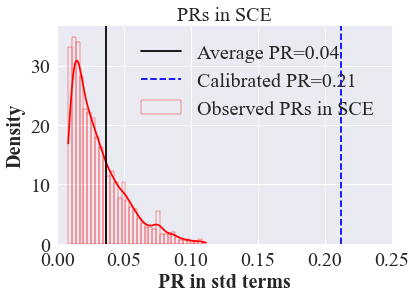

In [43]:
import seaborn as sns


plt.figure(figsize=(6,4))
plt.title('PRs in SCE')
sns.histplot(np.sqrt(PR_ind_av), 
             color="red", 
             kde=True, 
             stat="density", 
             label='Observed PRs in SCE',
             linewidth= 0.4,
             fill = False)

plt.axvline(np.sqrt(av_PR_SCE),
            color='black',
            label='Average PR={:.2f}'.format(np.sqrt(av_PR_SCE)))


plt.axvline(np.sqrt(est_PR_Low),
            linestyle='--',
            color='blue',
            label='Calibrated PR={:.2f}'.format(np.mean(np.sqrt(est_PR_Low))))

plt.xlim([0.0,0.25])
plt.xlabel('PR in std terms')
plt.legend(loc=0)


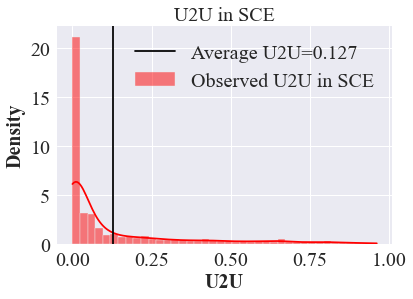

In [41]:
## distributions of U2U 

plt.figure(figsize=(6,4))
plt.title('U2U in SCE' )

#hist = plt.hist(prob_func(U2U_SCE),
#                bins = 20,
#                color='red',
#                 alpha = 0.3,
#                label='Dist of U2U',
#               density=True)

sns.histplot(prob_func(U2U_SCE), 
             color="red", 
             bins = 40,
             kde=True, 
             stat="density", 
             label='Observed U2U in SCE',
             linewidth= 0.4,
             fill = True)


plt.axvline(np.mean(prob_func(U2U_SCE)),
            color='black',
            label='Average U2U={:.3f}'.format(np.mean(prob_func(U2U_SCE))))

plt.xlabel('U2U')
plt.legend(loc=0)

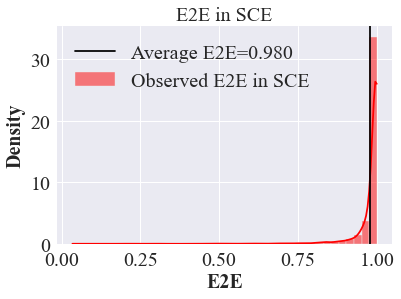

In [39]:
## distributions of E2E 

plt.figure(figsize=(6,4))
plt.title('E2E in SCE')

#hist = plt.hist(prob_func(E2E_SCE),
#                bins = 50,
#                color='red',
#                 alpha = 0.3,
#                label='Dist of E2E',
#               density=True)

sns.histplot(prob_func(E2E_SCE), 
             color="red", 
             bins = 40,
             kde=True, 
             stat="density", 
             label='Observed E2E in SCE',
             linewidth= 0.4,
             fill = True)

plt.axvline(np.mean(prob_func(E2E_SCE)),
            color='black',
            label='Average E2E={:.3f}'.format(np.mean(prob_func(E2E_SCE))))


plt.xlabel('E2E')
plt.legend(loc=0)

### Estimation of trucated log normal 

In [11]:
## estimating the parameters using SCE 

mu_PR_est_SCE, sigma_PR_est_SCE, sigma_xi_est_SCE = Est_PR_log_normal_simple(PR_ind_av,
                                                                            est_PR_Low,
                                                                            transform=True)
print('Estimated mean PR',str(mu_PR_est_SCE))
print('Estimated standard deviation in PR',str(sigma_PR_est_SCE))
print('Estimated wedge due to unobserved heterogeneity',str(sigma_xi_est_SCE))

PRs_grid = np.linspace(np.min(PR_ind_av),
                      np.max(PR_ind_av),
                      100)

PRs_sim_simple = np.exp(np.random.randn(10000)*sigma_PR_est_SCE+mu_PR_est_SCE)

Estimated mean PR -7.338062763214111
Estimated standard deviation in PR 1.2369657754898071
Estimated wedge due to unobserved heterogeneity 0.20894440114889973


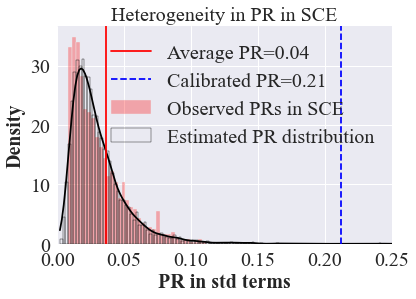

In [44]:
## plot simulated data based on log normal estimates and the observed PRs

#plt.hist(np.sqrt(PRs_sim_simple),
#        bins = 200,
#         color='red',
#        label='Estimated distribution in PRs',
#         alpha = 0.3,
#        density = True)

#plt.hist(np.sqrt(PR_ind_av),
#         bins = 200,
#         color='black',
#         label='Observed PRs in SCE',
#         density = True,
#         alpha=0.5)

plt.figure(figsize=(6,4))
plt.title('Heterogeneity in PR in SCE')

sns.histplot(np.sqrt(PR_ind_av), 
             color="red", 
             kde= False,  
             stat="density", 
             label='Observed PRs in SCE',
             linewidth= 0.4,
             fill = True,
            alpha =0.3)


sns.histplot(np.sqrt(PRs_sim_simple), 
             color="black", 
             kde=True, 
             stat="density", 
             label='Estimated PR distribution',
             linewidth= 0.4,
             fill = False)

plt.axvline(np.sqrt(av_PR_SCE),
            color='red',
            label='Average PR={:.2f}'.format(np.sqrt(av_PR_SCE)))

plt.axvline(np.sqrt(est_PR_Low),
            linestyle='--',
            color='blue',
            label='Calibrated PR={:.2f}'.format(np.mean(np.sqrt(est_PR_Low))))

plt.xlim([0.0,0.25])
plt.xlabel('PR in std terms')
plt.legend(loc=1)
plt.savefig('../Graphs/sce/log_normal_pr_fit.pdf')

In [45]:
## estimating the parameters using SCE 

mu_PRn_est_SCE, sigma_PRn_est_SCE, sigma_xi_n_est_SCE = Est_PR_log_normal_simple(PRn_ind_av,
                                                                                 est_PR_Low,
                                                                                transform=True)
print('Estimated mean nominal PR',str(mu_PRn_est_SCE))
print('Estimated standard deviation in nominal PR',str(sigma_PRn_est_SCE))
print('Estimated nominal wedge due to unobserved heterogeneity',str(sigma_xi_n_est_SCE))

PRns_grid = np.linspace(np.min(PRn_ind_av),
                      np.max(PRn_ind_av),
                      100)

PRns_sim_simple = np.exp(np.random.randn(10000)*sigma_PRn_est_SCE+mu_PRn_est_SCE)

Estimated mean nominal PR -8.647862325935161
Estimated standard deviation in nominal PR 1.3666519475774812
Estimated nominal wedge due to unobserved heterogeneity 0.2109915844867426


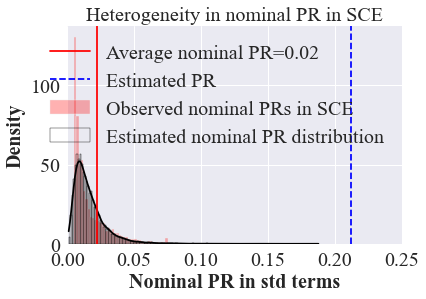

In [46]:
## plot simulated data based on log normal estimates and the observed PRs

plt.figure(figsize=(6,4))
plt.title('Heterogeneity in nominal PR in SCE')
#plt.hist(np.sqrt(PRns_sim_simple),
#        bins = 200,
#         color='red',
#        label='Estimated distribution in nominal PRs',
#         alpha = 0.3,
#        density = True)

#plt.hist(np.sqrt(PRn_ind_av),
#         bins = 200,
#         color='black',
#         label='Observed PRs in SCE',
#         density = True,
#         alpha=0.5)

sns.histplot(np.sqrt(PRn_ind_av), 
             color="red", 
             kde= False,  
             stat="density", 
             label='Observed nominal PRs in SCE',
             linewidth= 0.4,
             fill = True,
            alpha =0.3)


sns.histplot(np.sqrt(PRns_sim_simple), 
             color="black", 
             kde=True, 
             stat="density", 
             label='Estimated nominal PR distribution',
             linewidth= 0.4,
             fill = False)

plt.axvline(np.sqrt(av_PRn_SCE),
            color='red',
            label='Average nominal PR={:.2f}'.format(np.sqrt(av_PRn_SCE)))

plt.axvline(np.sqrt(est_PR_Low),
            linestyle='--',
            color='blue',
            label='Estimated PR')

plt.xlim([0.0,0.25])
plt.xlabel('Nominal PR in std terms')
plt.legend(loc=1)
plt.savefig('../Graphs/sce/log_normal_npr_fit.pdf')

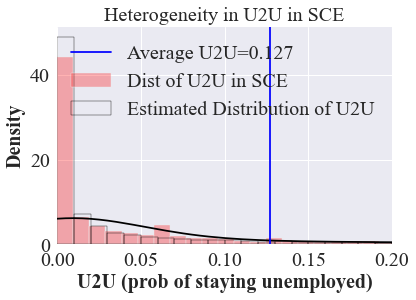

In [47]:
## estimating the parameters using SCE U2U and E2E 

shape_U2U, loc_U2U, scale_U2U = stats.lognorm.fit(U2U_SCE)
U2U_trans_mu_est, sigma_trans_U2U_est, loc_trans_U2U_est = np.log(scale_U2U), shape_U2U, loc_U2U

U2U_est_dist = stats.lognorm(s=shape_U2U,
                             loc=loc_U2U,
                             scale=scale_U2U)

U2U_grid = np.linspace(np.min(U2U_ind_av),
                      np.max(U2U_ind_av),
                      100)
U2U_pdfs = U2U_est_dist.pdf(U2U_grid)
U2U_draws = U2U_est_dist.rvs(size = 10000)

plt.figure(figsize=(6,4))
plt.title('Heterogeneity in U2U in SCE')

#hist = plt.hist(prob_func(U2U_SCE),
#                bins = 100,
#                color='black',
#                label='Dist of U2U',
#               density=True,
#               alpha=0.5)

#hist2 = plt.hist(prob_func(U2U_draws),
#                bins = 100,
#                color='red',
#                label='Dist of Simulated U2U',
#               density=True,
#               alpha=0.2)

sns.histplot(prob_func(U2U_SCE), 
             color="red", 
             bins = 100,
             kde= False,  
             stat="density", 
             label='Dist of U2U in SCE',
             linewidth= 0.4,
             fill = True,
            alpha =0.3)


sns.histplot(prob_func(U2U_draws), 
             color="black", 
             bins = 100,
             kde=True, 
             stat="density", 
             label='Estimated Distribution of U2U',
             linewidth= 0.4,
             fill = False)

plt.xlim(0.0,0.2)


plt.axvline(np.mean(prob_func(U2U_SCE)),
            color='blue',
            label='Average U2U={:.3f}'.format(np.mean(prob_func(U2U_SCE))))

plt.xlabel('U2U (prob of staying unemployed)')
plt.legend(loc=1)
plt.savefig('../Graphs/sce/log_normal_u2u_fit.pdf')

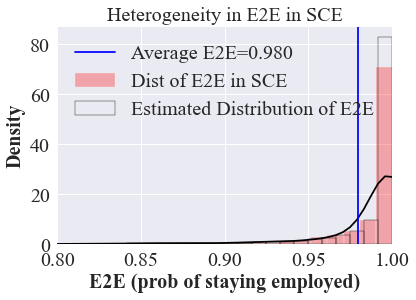

In [48]:
## estimating the parameters using SCE E2E

shape_E2E, loc_E2E, scale_E2E = stats.lognorm.fit(E2E_SCE)
E2E_trans_mu_est, sigma_trans_E2E_est, loc_trans_E2E_est = np.log(scale_E2E), shape_E2E, loc_E2E



E2E_draws = stats.lognorm.rvs(s = shape_E2E,
                             loc = loc_E2E,
                             scale = scale_E2E,
                             size = 10000)
plt.figure(figsize=(6,4))
plt.title('Heterogeneity in E2E in SCE')

#hist = plt.hist(prob_func(E2E_SCE),
#                bins = 100,
#                color='black',
#                label='Dist of E2E',
#               density=True,
#               alpha=0.5)

#hist2 = plt.hist(prob_func(E2E_draws),
#                bins = 100,
#                color='red',
#                label='Dist of Simulated E2E',
#               density=True,
#                alpha=0.2)

sns.histplot(prob_func(E2E_SCE), 
             color="red", 
             bins = 100,
             kde= False,  
             stat="density", 
             label='Dist of E2E in SCE',
             linewidth= 0.4,
             fill = True,
            alpha =0.3)

sns.histplot(prob_func(E2E_draws), 
             color="black", 
             bins = 100,
             kde=True, 
             stat="density", 
             label='Estimated Distribution of E2E',
             linewidth= 0.4,
             fill = False)


plt.xlim(0.8,1.0)
plt.axvline(np.mean(prob_func(E2E_SCE)),
            color='blue',
            label='Average E2E={:.3f}'.format(np.mean(prob_func(E2E_SCE))))

plt.xlabel('E2E (prob of staying employed)')
plt.legend(loc=0)
plt.savefig('../Graphs/sce/log_normal_e2e_fit.pdf')

## Do the same thing for expected wage growth  

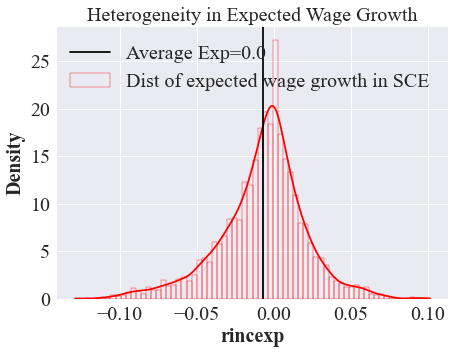

In [53]:
plt.figure(figsize=(7,5))
plt.title('Heterogeneity in Expected Wage Growth')
#hist = plt.hist(Exp_ind_av,
#                bins = 50,
#                color='red',
#                label='Dist of PRs',
#                alpha=0.3,
#               density=True)

sns.histplot(Exp_ind_av, 
             color="red", 
             kde=True, 
             stat="density", 
             label='Dist of expected wage growth in SCE',
             linewidth= 0.4,
             fill = False)

plt.axvline(av_Exp_SCE,
            color='black',
            label='Average Exp={:.1f}'.format(round(av_Exp_SCE)))

plt.legend(loc=0)

In [54]:
## expectation heterogeneity
shape_Exp, loc_Exp, scale_Exp = stats.lognorm.fit(Exp_ind_av)
Exps_sim_simple = stats.lognorm.rvs(s=shape_Exp,
                                 loc = loc_Exp,
                                 scale=scale_Exp,
                                 size = 1000)
exp_mu_est, sigma_exp_est, loc_exp_est = np.log(scale_Exp), shape_Exp, loc_Exp  # mu, sigma ## mu=-sigma^2/2 for mean-one log normal
#Exps_sim_simple = np.exp(np.random.randn(100000)*sigma_exp_est+exp_mu_est)+loc_Exp

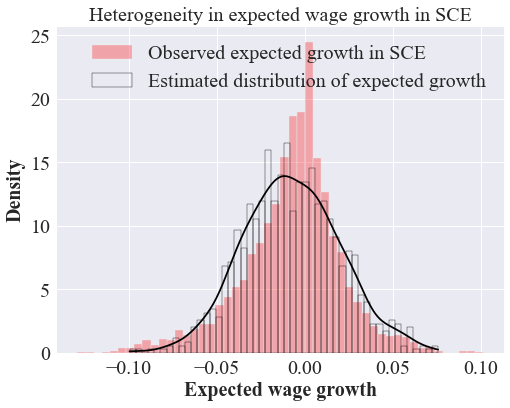

In [57]:
plt.figure(figsize=(8,6))

plt.title('Heterogeneity in expected wage growth in SCE')
#hist1= plt.hist(Exps_sim_simple,
#        bins = 100,
#         color='red',
#        label='Estimated distribution in expected growth',
#         alpha = 0.3,
#        density = True)

#hist2 = plt.hist(Exp_ind_av,
#         bins = 100,
#         color='black',
#         label='Observed expected growth in SCE',
#         density = True,
#         alpha=0.5)

sns.histplot(Exp_ind_av, 
             color="red", 
             kde= False,  
             bins = 50,
             stat="density", 
             label='Observed expected growth in SCE',
             linewidth= 0.4,
             fill = True,
            alpha =0.3)


sns.histplot(Exps_sim_simple, 
             color="black",
            bins = 50,
             kde=True, 
             stat="density", 
             label='Estimated distribution of expected growth',
             linewidth= 0.4,
             fill = False)


plt.xlabel('Expected wage growth')
plt.legend(loc=1)
plt.savefig('../Graphs/sce/log_normal_exp_fit.pdf')

In [58]:
## ## store all data 
PR_est_dict = {'mu_pr':mu_PR_est_SCE,
              'sigma_pr':sigma_PR_est_SCE,
              'sigma_xi':sigma_xi_est_SCE,
              'std_exp': std_Exp_SCE,
               'mu_exp':exp_mu_est,
               'sigma_exp':sigma_exp_est,
               'loc_exp':loc_exp_est,
               'mu_trans_U2U':U2U_trans_mu_est,
               'sigma_trans_U2U':sigma_trans_U2U_est,
               'loc_trans_U2U':loc_trans_U2U_est,
                'mu_trans_E2E':E2E_trans_mu_est,
               'sigma_trans_E2E':sigma_trans_E2E_est,
               'loc_trans_E2E':loc_trans_E2E_est,
              }

pickle.dump(PR_est_dict,open('./parameters/PR_est.pkl','wb'))